<a href="https://colab.research.google.com/github/VuongTuanKhanh/Funix-Capstone-Project/blob/main/notebooks/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤫 Setting Up

## 💽 Create Google Drive repository

In [ ]:
import json
import random
import os, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=25,25
from random import randrange, choice
from IPython.display import display, clear_output, HTML

We will need to mount with **Google Drive** as we treat it as a local file. Whether you are using **Jupyter Notebook** instead of **Google Colab**, you can skip this step. 

However, since our data set is huge, it would not be feasible to store it locally. Instead, I recommend using **Google Drive** as a cloud storage drive, which will help us store more efficiently and access it more easily in the future.

In [ ]:
# Check the ipython interpreter is being used
if 'google.colab' in str(get_ipython()):
    # Import Library
    from google.colab import drive
    # Mounting Drive Folder
    try:
        drive.mount('/content/drive')
    except:
        print("Mounting Fail")
    else:
        print("Mouting Success")
    finally:
        print("Mounting process is completed")

    # Define the path to the Google Drive Folder
    drive_path = "/content/drive/MyDrive/Funix-Capstone-Project"

    # Clone the repo if the folder whether it is not existed
    if not os.path.exists(drive_path):
        # Install 'git' module if needed
        try:
            from git import Repo
        except ModuleNotFoundError:
            import sys, subprocess
            print("Installing 'git' module")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'gitpython'])

        # Import 'repo' from 'git' module
        from git import Repo
        # Create project folder
        os.mkdir(drive_path)
        # Clone the repo
        Repo.clone_from("https://github.com/VuongTuanKhanh/Funix-Capstone-Project", drive_path)
        print("Cloning git repo")


    # Navigate to the folder
    os.chdir(drive_path)

Mounted at /content/drive
Mouting Success
Mounting process is completed


To run the project, you need to install the packages specified in the requirements section. 

The installation will be done automatically when all the packages have been specified in advance and done through the shell command, automatically installed into the Linux operating system of the virtual machine.

In [ ]:
# Install the required package
!pip install -r ./requirements.txt > /dev/null

# Clearing the output
clear_output()

## 🔬 Accessing AOT Dataset

After we have finished setting up the environment, we will proceed to access the data. Detailed information on the data as well as example steps of exploration can be found [here](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/wiki/About-the-AOT-dataset) and [here](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/blob/main/notebooks/Dataset_Exploration.ipynb). For more information you can refer to my Github Repo Wiki located at https://github.com/VuongTuanKhanh/Funix-Capstone-Project


We will need to load the details of all flights based on the grouthtruth information provided in the original dataset. Execution will be done automatically based on my self-defined library in the core directory, including setting up paths as well as loading grouthtruth information for all flights. This information is then saved into a single object for easy access.


Note, it is necessary to consider loading the whole data or just a part of the data when the original data set is really large, up to 13Tb, making it sometimes impossible to load and store each record. Instead, you can choose to load a partial data including 500Gb of valid encounters via the `partial=True` option.


Detailed information about the dataset as well as `grouthtruth` and `valid_encounter` formats can be found [here](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/wiki/Downloading-AOT-dataset).

In [ ]:
from core.helper import initialize, load_data

# Initialize the enviroment
initialize(42)

# Loading the dataset and save to a variable
# Whether you want to load the entire dataset, use partial=False
dataset = load_data()

# Print out the dataset
print(dataset)

2021-08-29 08:10:00.620 | INFO     | core.dataset:load_gt:28 - Loading ground truth...
2021-08-29 08:10:42.524 | INFO     | core.dataset:load_gt:28 - Loading ground truth...
2021-08-29 08:11:20.450 | INFO     | core.dataset:load_gt:28 - Loading ground truth...


Dataset(num_flights=3438)


## 📡 Downloading all images for training

Please note, **downloading image for each frame** would be slower, so when using for training downloading whole dataset is preferred. 

You can download full dataset using following commands:

```python
for flight in dataset.flights:
    # This can take upto 5-10 mins on Colab
    flight.download()
```

The original data is stored on the **AWS server**, so you can also mount the data directly by using **EFS** or **s3fs**. End-to-end example can be found [here](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/blob/main/notebooks/EFS_and_S3FS_example.ipynb).


# 🗃 Baseline - Pre-train model with YOLOv3

There is no right way to choose the perfect model for a machine learning problem. We have to try them out to see what is the best fit for our problems. 

There are thousands of methods to solve this problem. However, one of the most popular nowaday is the **YOLO** algorithm with many different versions. So, there is no reason not to choose **YOLO** as the baseline for our study.

Baseline is defined as our first approach to solving a real world problem. Specifically here, we are talking about **YOLO**, should we blindly test the latest version right away? Certainly not, because sometimes simpler algorithms do better at solving a particular problem.

For the sake of taking the most rudimentary and naive approach, we will choose the earliest algorithm, **YOLO version 3**.

All **YOLO** algorithms require a lot of computation, so I recommend using **GPU** to speed up computation. Use the command below to get the current **GPU** information of the virtual machine.

## ⚗ Get GPU information

In [ ]:
from core.helper import run_shell

# This self-defined command is used to execute shell commands
run_shell("nvidia-smi")

Output: Sat Aug 28 08:30:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


### YOLOv3 configuration

The following cells will clone **darknet** from **AlexeyAB**'s famous repository, adjust the `Makefile` to enable **OPENCV** and **GPU** for **darknet** and then build **darknet**.

In addition to cloning the `darknet` repo, you will also need to change some information in the `Makefile` to enable the **GPU**. All are pre-installed in the constructor of the self-defined class `Yolo_V3`.

In [ ]:
# Import self-define class
from core.yolo_v3 import Yolo_V3
# Create an instance for the class
yolo_v3 = Yolo_V3()

Next, we need to determine the current version of **CUDA** to ensure it is suitable for the project using the following command:

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


Execute the make command to complete the configuration. Do not worry about any warnings when you run the `!make` cell, the warnings come from the original repo to inform conditions of dependences.


Without executing on `make`, you will not be able to train the model in the next steps. One way around that is to execute the following command:

```
chmod +x *.sh
```

In [ ]:
# make darknet (build)
!make
clear_output()

## Testing Pre-train YOLOv3

### 📋 Try YOLOv3 on command objects

First, we need to download the **Pre-trained weights** for our model. **YOLOv3** has been trained already on the **COCO** dataset which has 80 classes that it can predict. We will grab these pretrained `weights` so that we can run **YOLOv3** on these pretrained classes and get detections.

In [ ]:
yolo_v3.wget_package("yolov3.weights", "https://pjreddie.com/media/files/yolov3.weights")

We are now able to run **Detections** with **Darknet** and **YOLOv3**!

**Darknet** is now built and ready to run detections using **YOLOv3** in the cloud! You can find out which sorts of classes the pretrained **YOLOv3** weights can detect by clicking here. [COCO CLASSES](http://cocodataset.org/#explore)

The object detector can be run using the following command

```bash
!./darknet detect <path to config> <path to weights> <path to image>
```
**Darknet** comes with a few images already installed in the darknet/data/ folder.

**Note:** After running detections **OpenCV** can't open the image instantly in the cloud so we must run: 
```bash
yolo_v3.imShow('predictions.jpg')
```
This will output the image with the detections shown. The most recent detections are always saved to `predictions.jpg`

Try out the examples below for yourself!

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5, 

Let's check the result

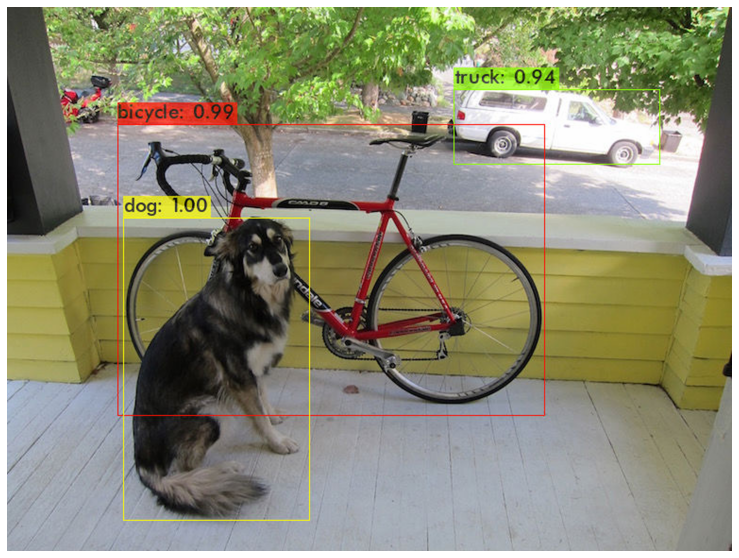

In [ ]:
yolo_v3.imShow("predictions.jpg")

WOW this is magic! As we can see here, the pre-trained model makes pretty good predictions on common objects. You can try it yourself with other images.

### 📇 Try Pre-train model on AOT Dataset

And now, we will test our pre-train **YOLOv3** model on the **AOT** dataset to see how it performs. First, let's randomly select a frame and its symbol.

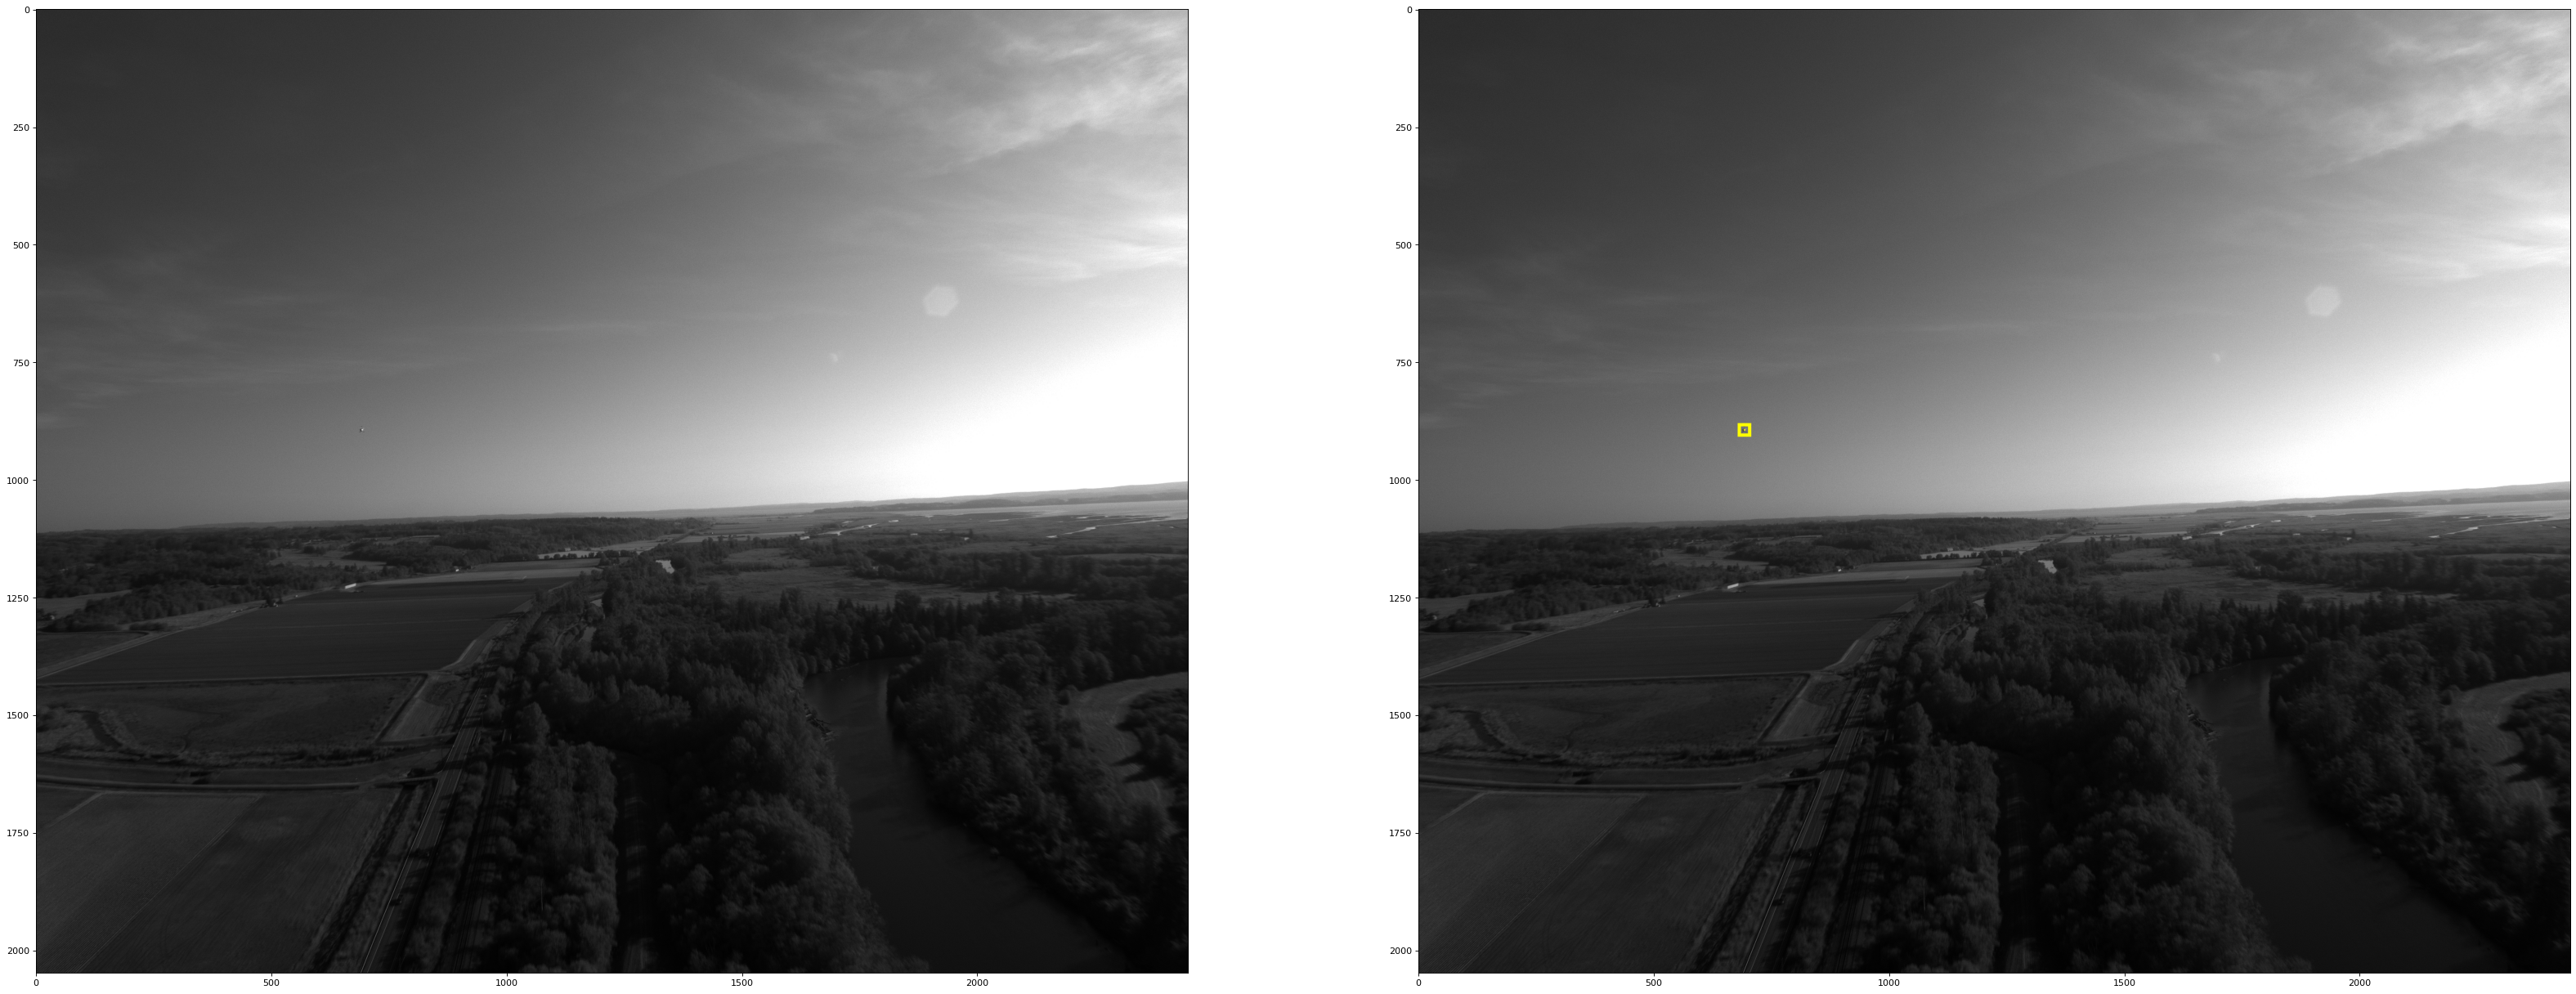

Images/49f4d9ca19004b81b905db6acab3d7d8/153610618516003474949f4d9ca19004b81b905db6acab3d7d8.png


In [ ]:
from core.helper import random_frame, image_and_annotation, plot_image_and_annotation

# Get the id and the frame of a random image
id, frame = random_frame(dataset, 2)
# Get the image and it's annotation
image, annotated_image = image_and_annotation(frame)
# Print out the image and it's annotation
plot_image_and_annotation(image, annotated_image)
# Get the id of the image - This will be use to feed our pre-train model
print(id)

As we can see, this is indeed a difficult example even for us, when the object is extremely small and cannot be labeled with the naked eye. That's why we can't use some tools available today like LabelImg because small objects are a huge challenge for the human eye. Therefore, in the next steps, we will study how to label train data through `grouthtruth`. And we can also guess that the pre-train model will not work well on this particular dataset as the model is trained on common objects, with much larger sizes. So now, we will proceed to use **YOLOv3** on the selected frame. We will use the settings and weights available at the path `cfg/yolov3.cfg` and `yolov3.weights`.

The format of the `predict` command is:

```
!./darknet detect <config_file> <yolov_weights> <image_path>
```

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights ../data/part1/Images/49f4d9ca19004b81b905db6acab3d7d8/153610618516003474949f4d9ca19004b81b905db6acab3d7d8.png

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

Finally, let's check for the results. The results will be returned and automatically saved in memory with the name `predictions.jpg`.

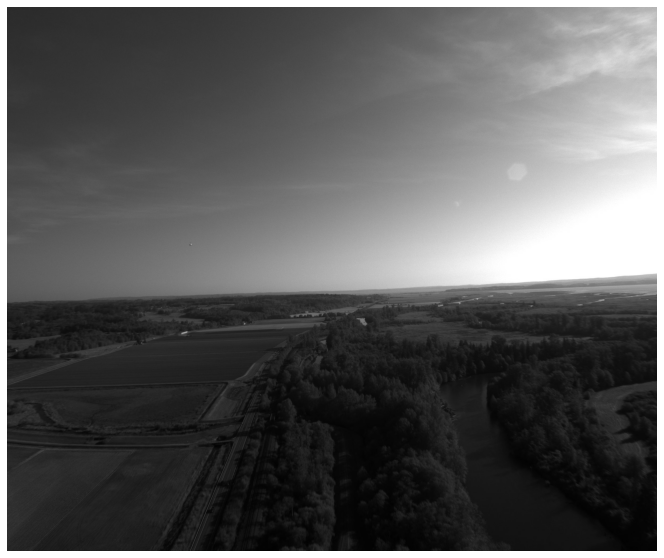

In [ ]:
yolo_v3.plot_image('predictions.jpg')

As we expected, the pre-train model was unable to make predictions for the **AOT** dataset.

In conclusion, the pre-train **YOLOv3** model can make good predictions on normal data sets, larger object sizes and not really suitable for **AOT** dataset. Our baseline can work well with larger frames, but it will take a lot of improvement to be able to make predictions on smaller objects.

Check out [this](https://github.com/VuongTuanKhanh/Funix-Capstone-Project/blob/main/notebooks/Pre_train_YOLOv3_Example.ipynb) for more **Pre-train YOLOv3** explorations on **AOT dataset**

# 💟 Thanks!
Thanks for following along this tutorial, I hope it worked well for all of you!